<a href="https://colab.research.google.com/github/ywenlu/colab/blob/master/Yang_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
import tensorflow as tf
import requests
import os
resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
if resp.status_code != 200:
  print("Failed to switch the TPU to TF {}".format(version))

     |████████████████████████████████| 516.2MB 24kB/s 
     |████████████████████████████████| 399kB 57.4MB/s 
     |████████████████████████████████| 460kB 60.7MB/s 
     |████████████████████████████████| 3.0MB 65.2MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
  Found existing installation: tensorflow-gcs-config 2.3.0
    Uninstalling tensorflow-gcs-config-2.3.0:
      Successfully uninstalled tensorflow-gcs-config-2.3.0


In [3]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [4]:
!pip install -q efficientnet albumentations gcsfs >> /dev/null

In [5]:
import pandas as pd, numpy as np
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from google.colab import drive
import gcsfs
import random
from termcolor import colored
import time

GCS_PATH_2020_256 = "gs://kds-f8af4bf2f6c765dbd327683a170e364332a1750658e910153e98d0d5"
GCS_PATH_2019_256 = "gs://kds-436e76b7e255e4499d5d11da9d7ab87646e271e08ec1d546f310ec00"
GCS_PATH3_256 = "gs://kds-9e5912113bdca38bda75e6858a127bdfd0f26951b4f6843c45974106"

GCS_PATH_2020_384 = "gs://kds-71b679af6661316328cfa122f5342b4a84fe0c7c1135d809fbee8ca4"
GCS_PATH_2019_384 = "gs://kds-6f9d2143e7fe97eccac0219c1aacb107a234b440670f250683ba40ee"
GCS_PATH3_384 = "gs://kds-c557c41c0102dc29c1ed0386c4746604d132a95f29eeacf42e522004"

GCS_PATH_2020_512 = "gs://kds-458e4ec4a30e5d927b21efd0633fb2c0a091245fe8db3c415fde5da6"
GCS_PATH_2019_512 = "gs://kds-203bea6cc14c2866536ac303b09a6e77a6b3d0a371e96b680836433c"
GCS_PATH3_512 = "gs://kds-00457c0c555bfdd50b1d2db15abd7feb19d4795037f919a3dc0abbee"

GCS_PATH_2020_768 = "gs://kds-cfb16ed5f55adb5ab35a75a2fe74c3dc11a4b869dc8cfb3d9b1759e1"
GCS_PATH_2019_768 = "gs://kds-79d9c56dcae7978f98a6bbe8318ac6866ba4778fc95c5871fcfd0f03"
GCS_PATH3_768 = "gs://kds-032edf427ad6e338f5392f73759ff404a1a3f25c2abdc4995136de30"

GCS_PATH_2020_1024 = "gs://kds-6c7a250f2696ec7a21fab126dbe7072eb2176d50c396944eb9121399"
GCS_PATH_2019_1024 = "gs://kds-dd5bf3fbefb159e1b6fa1d24e7b1bf4e3d9656a7e98be1baf3f40115"
GCS_PATH3_1024 = "gs://kds-d284f181c7472f4d3ca007bcb2e67824aa5a3a2a588d7a878bc30292"

fs = gcsfs.GCSFileSystem(project='siic')

In [14]:
output_path = '/content/drive/My Drive/kaggle/SIIM_ISIC/outputs'
version_name = 'b5_00_yang'
checkpoint = '/content/drive/My Drive/kaggle/SIIM_ISIC/weights/'+version_name

import os
## Check path for checkpoint 
if not os.path.exists(checkpoint):
    os.makedirs(checkpoint)
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [15]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384]*FOLDS

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0,0,0]
INC2018 = [1,1,1,1,1]
M1 = [1,1,1,1,1]
M2 = [1,1,1,1,1]
M3 = [1,1,1,1,1]
M4 = [1,1,1,1,1]
# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS #16/b6, 32/b5, 
EPOCHS = [18]*FOLDS

# WHICH EFFICIENTNET B? TO USE
EFF_NETS = [5]*FOLDS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 16

base_lr = 1e-4
stop_patience = 5
scheduler_patience = 2
skip_folds = [0,1,2]#[0,1,2,3,4]

In [16]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            #strategy = tf.distribute.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.105.23.202:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.105.23.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.105.23.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [17]:
GCS_PATH = [None]*FOLDS; GCS_PATH2 = [None]*FOLDS; GCS_PATH3 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    GCS_PATH[i] = GCS_PATH_2020_384
    GCS_PATH2[i] = GCS_PATH_2019_384
    GCS_PATH3[i] = GCS_PATH3_384
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[0] + '/test*.tfrec')))

In [18]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [19]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

class GridMask():
    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        # super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)


In [44]:
def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    # Andrew Anikin suggestion
    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

In [103]:
def simple_shade_of_grey_cvt(img):
    img =tf.dtypes.cast(img, tf.float32)
    img_power = tf.pow(img, power)
    rgb_vec = tf.pow(tf.reduce_mean(img_power, (0,1)), 1/power)
    rgb_norm = tf.sqrt(tf.reduce_sum(tf.pow(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = tf.cast(1,tf.float32)/(rgb_vec*tf.sqrt(tf.cast(3,tf.float32)))
    img = tf.multiply(img, rgb_vec)
    img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)
    return tf.cast(img,tf.uint8)

In [11]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

## Multi-scale training
def random_IMG_size(img, dim):
    reshape_ratio = tf.random.uniform([1], 0.3,1 )[0]
    reshape_prob = 0.5
    if tf.random.uniform([1])[0]<reshape_prob:
        img = tf.image.resize(img, 
                              [int(dim*reshape_ratio), int(dim*reshape_ratio)])
        img = tf.image.resize_with_crop_or_pad(img, int(1.2*dim), int(1.2*dim))
        img = tf.image.random_crop(img, [dim,dim, 3])
    return img

## Grid Mask
def add_mask(img, dim):
    gm = GridMask(mode=0, num_grid=3)
    gm.init_masks(dim,dim)
    init_masks = tf.cast(gm.masks[0], dtype='float32')
    init_masks = tf.stack([init_masks]*3, axis=2)
    rotated_masks = transform(init_masks, DIM=init_masks.shape[0])
    mask_single = tf.image.random_crop(rotated_masks,[dim,dim,3])
    #mask_batch = tf.expand_dims(mask_single, axis=0)
    img = img*mask_single
    return img


@tf.function
def data_augment(img, dim, val):
    img = transform(img,DIM=dim)
    
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    #img = tf.image.random_hue(img, 0.01)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    if not val:

        ## Add Grid Mask
        gm_ratio = 0.75
        if tf.random.uniform([1])[0] < gm_ratio:
            img=add_mask(img, dim)
    # ## Multi-scale
    # img = random_IMG_size(img, dim) 
    
    return img

def prepare_image(img, augment=True, dim=256, val=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = simple_shade_of_grey_cvt(img)
    img = tf.cast(img, tf.float32) / 255.0

    #img = tf.image.random_crop(img, [IMG_SIZES[0], IMG_SIZES[0], 3])
    #if val:
        #img = tf.image.random_crop(img, [IMG_SIZES[0], IMG_SIZES[0], 3])
    #else:
        #img = tf.image.resize(img, [IMG_SIZES[0], IMG_SIZES[0]])
    if augment: 
        img = data_augment(img, dim, val)
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)



In [12]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, val = True,
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO) 
    '''  
    if labeled:
        ds = ds.map(lambda img, label: (prepare_image(img, augment=augment, dim=dim, val=val), 
                                               tf.cast(label, tf.float32)), 
                    num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda img, imgname: (prepare_image(img, augment=augment, dim=dim, val=val), 
                                               imgname), 
                    num_parallel_calls=AUTO)
    '''
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim, val=val), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [13]:
# fold=0

# Examples = list(get_dataset(files_train, augment=True, shuffle=True, repeat=True, val=True,
#                 dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]).take(2).as_numpy_iterator())
# image_examples = Examples[0][0]
# y_examples = Examples[0][1]
# IMG_SIZE = IMG_SIZES[0]
# plt.figure(figsize=(10,10))
# for i in range(16):
#     image_plot = np.array(image_examples[i]).reshape([IMG_SIZE,IMG_SIZE,3])
#     plt.subplot(4,4,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(image_plot, cmap=plt.cm.binary)
#     plt.title(y_examples[i])

#     # print((image_plot<0).sum())
# plt.show()

In [14]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [15]:
feature_layes = ['block6a_expand_activation', 'block4a_expand_activation', 'block3a_expand_activation', 'block2a_expand_activation']
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]
def Focal_Loss(y_true, y_pred, alpha=0.75, gamma=2, weight=5):
    #y_true = K.cast(K.flatten(y_true), dtype='float32')
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    BCE = K.binary_crossentropy(y_true, y_pred)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return BCE+weight*focal_loss

def build_model(dim=128, ef=0):
    # inp = tf.keras.layers.Input(shape=(dim,dim,3))
    # base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    #inp = tf.keras.layers.Input(shape=(None,None,3))
    base = EFNS[ef](input_shape=(None,None,3),weights='noisy-student',include_top=False)

    #x = base(inp)
    skips = ([base.get_layer(name=i).output if isinstance(i, str)
              else backbone.get_layer(index=i).output for i in feature_layes])
    inp = base.input
    top = base.output
    #x = tf.keras.layers.Dropout(0.2)(x)
    block6 = tf.keras.layers.GlobalAveragePooling2D()(skips[0])
    block4 = tf.keras.layers.GlobalAveragePooling2D()(skips[1])
    #block3 = tf.keras.layers.GlobalAveragePooling2D()(skips[2])
    #block2 = tf.keras.layers.GlobalAveragePooling2D()(skips[3])
    block_top = tf.keras.layers.GlobalAveragePooling2D()(top)
    x = tf.keras.layers.Concatenate(axis=-1)([block6,block4,block_top])
    #x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=Focal_Loss,metrics=['AUC'])
    return model  

In [ ]:
#model = build_model()

In [ ]:
# model.summary()

In [16]:
class ReloadBest(tf.keras.callbacks.Callback):
  def __init__(self, model, fold):
      self.model = model
      self.lr = base_lr
      self.best_result = 0
      self.best_loss = 100000
      self.scheduler_counter = 0
      self.early_stopping_counter = 0
      self.fold = fold
      self.time_now = time.time()
  def on_epoch_end(self, epoch, logs):
      if logs['val_auc'] > self.best_result:
          self.scheduler_counter = 0
          self.early_stopping_counter = 0
          self.best_result = logs['val_auc']
          color = 'red'
          self.model.save(checkpoint+'/fold-%i.h5'%fold)
          #checkpoint+'/fold-%i-{epoch:02d}-{val_loss:.4f}-{val_auc:.4f}.h5'%fold
      else:
          color = None
          self.scheduler_counter += 1
          self.early_stopping_counter += 1
      if logs['val_loss'] < self.best_loss:

          self.best_loss = logs['val_loss']
          if color is None:
              color = 'green'
              self.scheduler_counter = 0
              self.early_stopping_counter = 0

      elapsed_time = time.time() - self.time_now
      self.time_now = time.time()
      print(colored('Epoch{}({})  loss={:.5f}  val_loss={:.5f}  auc={:.5f}   val_auc={:.5f}  lr={:.5f}  time={:.1f}s'.format(
          epoch + 1, self.early_stopping_counter, logs['loss'], logs['val_loss'], logs['auc'], logs['val_auc'], self.lr, elapsed_time), color))
      if self.early_stopping_counter >= stop_patience:
          self.model.stop_training = True
          return
      if self.scheduler_counter >= scheduler_patience:
          self.lr = K.get_value(self.model.optimizer.lr)*0.5
          self.model.load_weights(checkpoint+'/fold-%i.h5'%fold)
          K.set_value(self.model.optimizer.lr, self.lr)
          self.scheduler_counter = 0

In [17]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 1
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Loading best model...
Predicting OOF with TTA...
205/204 [==============================] - 67s 327ms/step
Predicting Test with TTA...
172/171 [==============================] - 114s 660ms/step
#### FOLD 1 OOF AUC with TTA = 0.926


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 2
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Loading best model...
Predicting OOF with TTA...
205/204 [==============================] - 68s 333ms/step
Predicting Test with TTA...
172/171 [==============================] - 103s 598ms/step
#### FOLD 2 OOF AUC with TTA = 0.924


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 3
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Loading best model...
Predicting OOF with TTA...
205/204 [==============================] - 68s 333ms/step
Predicting Test with TTA...
172/171 [==============================] - 102s 592ms/step
#### FOLD 3 OOF AUC with TTA = 0.946


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 4
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Training...
Epoch 1/18
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


154/154 [==============================] - 182s 1s/step - auc: 0.8922 - loss: 0.7095 - val_auc: 0.8047 - val_loss: 0.3847
Epoch 2/18
154/154 [==============================] - 153s 994ms/step - auc: 0.9147 - loss: 0.6373 - val_auc: 0.8733 - val_loss: 0.2062
Epoch 3/18
154/154 [==============================] - 155s 1s/step - auc: 0.9289 - loss: 0.5903 - val_auc: 0.9124 - val_loss: 0.1739
Epoch 4/18
154/154 [==============================] - 144s 933ms/step - auc: 0.9367 - loss: 0.5638 - val_auc: 0.8281 - val_loss: 0.4640
Epoch 5/18
154/154 [==============================] - 164s 1s/step - auc: 0.9431 - loss: 0.5360 - val_auc: 0.8635 - val_loss: 0.2161
Epoch 6/18
154/154 [==============================] - 154s 1s/step - auc: 0.9458 - loss: 0.5237 - val_auc: 0.9202 - val_loss: 0.1648
Epoch 7/18
154/154 [==============================] - 144s 932ms/step - auc: 0.9490 - loss: 0.5130 - val_auc: 0.9191 - val_loss: 0.1633
Epoch 8/18
154/154 [==============================] - 153s 997ms/step -

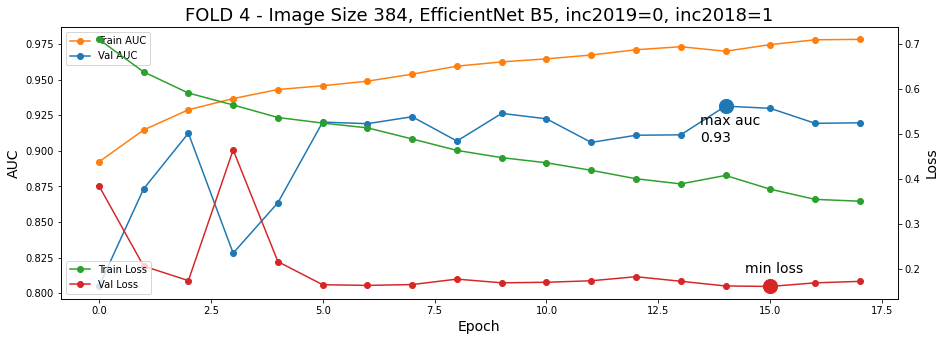

INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.112.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
#### FOLD 5
#### Image Size 384 with EfficientNet B5 and batch_size 256
#### Using 2018+2017 external data
#### Upsample MALIG-1 data (2020 comp)
#### Upsample MALIG-2 data (ISIC website)
#### Upsample MALIG-3 data (2019 comp)
#### Upsample MALIG-4 data (2018 2017 comp)
#########################
Training...
Epoch 1/18
154/154 [==============================] - 177s 1s/step - auc: 0.8801 - loss: 0.7749 - val_auc: 0.8570 - val_loss: 0.2202
Epoch 2/18
154/154 [==============================] - 153s 994ms/step - auc: 0.9171 - loss: 0.6249 - val_auc: 0.8748 - val_loss: 0.1970
Epoch 3/18
154/154 [==============================] - 154s 997ms/step - auc: 0.9308 - loss: 0.5805 - val_auc: 0.8961 - val_loss: 0.2058
Epoch 4/18
154/154 [==============================] - 144s 934ms/step - auc: 0.9373 - loss: 0.5575 - val_auc: 0.8880 - val_loss: 0.2270
Epoch 5/18
154/154 [==============================] - 154s 997ms/step - auc: 0.9435 - loss: 0.5349 - val_auc: 0.8998 - val_l

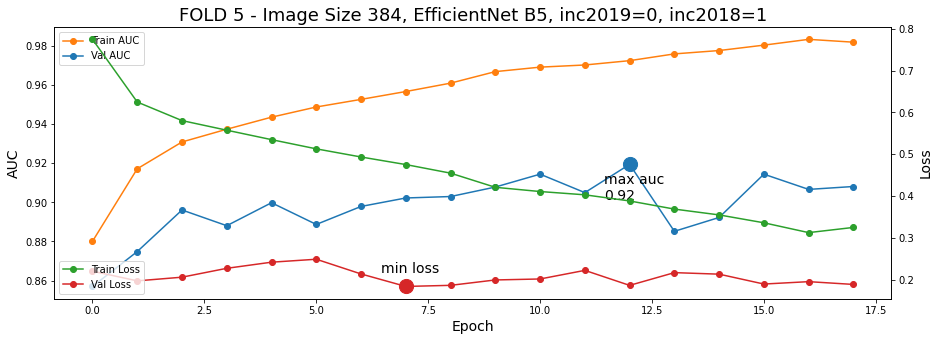

In [19]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
preds = np.zeros((count_data_items(files_test),1))
losses = []
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IMG_SIZES[fold],EFF_NETS[fold],BATCH_SIZES[fold]*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
    if INC2019[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
        print('#### Using 2019 external data')
    if INC2018[fold]:
        files_train += tf.io.gfile.glob([GCS_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
        print('#### Using 2018+2017 external data')
    for k in range(M1[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        print('#### Upsample MALIG-1 data (2020 comp)')
    for k in range(M2[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT+15])
        print('#### Upsample MALIG-2 data (ISIC website)')
    for k in range(M3[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1+30])
        print('#### Upsample MALIG-3 data (2019 comp)')
    for k in range(M4[fold]):
        files_train += tf.io.gfile.glob([GCS_PATH3[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+30])
        print('#### Upsample MALIG-4 data (2018 2017 comp)')
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([GCS_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH[fold] + '/test*.tfrec')))
    

    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES[fold],ef=EFF_NETS[fold])
    
    test_batch_scale = 2
    if fold not in skip_folds:    
        # SAVE BEST MODEL EACH FOLD
        sv = tf.keras.callbacks.ModelCheckpoint(
            checkpoint+'/fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
            save_weights_only=True, mode='max', save_freq='epoch')
      
        # TRAIN
        print('Training...')
        history = model.fit(
            get_dataset(files_train, augment=True, shuffle=True, repeat=True,val=False,
                    dim=IMG_SIZES[fold], batch_size = BATCH_SIZES[fold]), 
            epochs=EPOCHS[fold], callbacks = [sv,get_lr_callback(BATCH_SIZES[fold])] #[ReloadBest(model,fold)]
            steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
            validation_data=get_dataset(files_valid,augment=False,shuffle=False,
                    repeat=False,dim=IMG_SIZES[fold]), class_weight = {0:1,1:2},
            verbose=VERBOSE
        )
        
        print('Loading best model...')
        model.load_weights(checkpoint+'/fold-%i.h5'%fold)
        
        # PREDICT OOF USING TTA
        print('Predicting OOF with TTA...')
        ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*test_batch_scale)
        ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/test_batch_scale/REPLICAS
        pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
        oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
        #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))
        
        # GET OOF TARGETS AND NAMES
        ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=True, return_image_names=True)
        oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
        oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
        ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                    labeled=False, return_image_names=True)
        oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
        
        # PREDICT TEST USING TTA
        print('Predicting Test with TTA...')
        ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
                repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*test_batch_scale)
        ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/test_batch_scale/REPLICAS
        pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]
        
        # REPORT RESULTS
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))
        
        # PLOT TRAINING

        if DISPLAY_PLOT:
          plt.figure(figsize=(15,5))
          plt.plot(np.arange(len(history.history['auc'])),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
          plt.plot(np.arange(len(history.history['auc'])),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
          x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
          xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
          plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
          plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
          plt.legend(loc=2)
          plt2 = plt.gca().twinx()
          plt2.plot(np.arange(len(history.history['auc'])),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
          plt2.plot(np.arange(len(history.history['auc'])),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
          x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
          ydist = plt.ylim()[1] - plt.ylim()[0]
          plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
          plt.ylabel('Loss',size=14)
          plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                  (fold+1,IMG_SIZES[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
          plt.legend(loc=3)
          plt.show()
    else:   
        print('Loading best model...')
        #continue
        model.load_weights(checkpoint+'/fold-%i.h5'%fold)
        #model.load_weights('/content/drive/My Drive/siim/model/eff-b3/fold-0.h5')
        '''
        ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                labeled=True, return_image_names=True)
        loss, auc = model.evaluate(ds_valid)
        losses.append(loss)
        print('loss:',loss)
        '''
        # PREDICT OOF USING TTA
        print('Predicting OOF with TTA...')
        ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
              repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*test_batch_scale)
        ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZES[fold]/test_batch_scale/REPLICAS
        pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
        oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
        #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))

        # GET OOF TARGETS AND NAMES
        ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
              labeled=True, return_image_names=True)
        oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
        oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
        ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                  labeled=False, return_image_names=True)
        oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

        # PREDICT TEST USING TTA
        print('Predicting Test with TTA...')
        ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
              repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4)
        ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
        pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]

        # REPORT RESULTS
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        #oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC with TTA = %.3f'%(fold+1,auc)) 
          

In [20]:
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
# df_oof.to_csv(f'{output_path}/OOF_{version_name}.csv',index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.928


,image_name,target,pred,fold
0,ISIC_2637011,0,0.018700,0
1,ISIC_0076262,0,0.004401,0
2,ISIC_0074268,0,0.000035,0
3,ISIC_0015719,0,0.000031,0
4,ISIC_0082543,0,0.000736,0


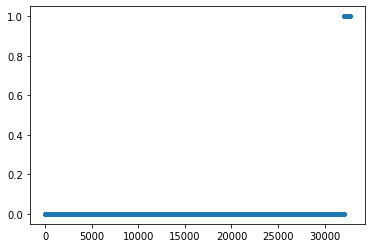

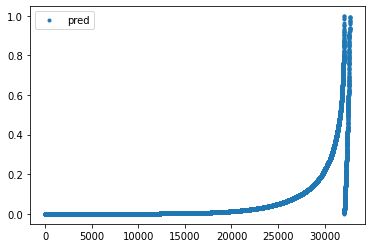

In [ ]:
analyse = pd.DataFrame({"name":names,'pred':oof,'true':true}).sort_values(['true','pred']).reset_index(drop=True)
plt.figure()
plt.plot(analyse['true'],'.',label='true')
plt.figure()
plt.plot(analyse['pred'],'.',label='pred')
plt.legend()

In [ ]:
# high FN/FP
threshold = 0.5
hfn_img_ls = analyse.loc[(analyse['true']==1)&(analyse['pred']<threshold),'name'].to_list()
hfp_img_ls = analyse.loc[(analyse['true']==0)&(analyse['pred']>threshold),'name'].to_list()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


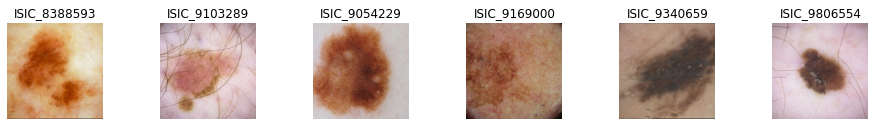

In [ ]:
ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                  labeled=False, return_image_names=True)
hfn_imgs = []
nb_show = 12
cur_nb = 0
plt.figure(figsize=(16,6))
for img, img_name in iter(ds.unbatch()):
    img_name_d = img_name.numpy().decode("utf-8")
    if img_name.numpy().decode("utf-8") in hfp_img_ls:
        cur_nb = cur_nb+1
        plt.subplot(int(nb_show/6+1), 6, cur_nb%6+1)
        plt.title(img_name_d)
        plt.imshow(img)
        plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


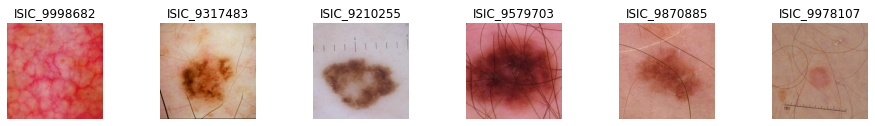

In [ ]:
ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                  labeled=False, return_image_names=True)
hfn_imgs = []
nb_show = 12
cur_nb = 0
plt.figure(figsize=(16,6))
for img, img_name in iter(ds.unbatch()):
    img_name_d = img_name.numpy().decode("utf-8")
    if img_name.numpy().decode("utf-8") in hfn_img_ls:
        cur_nb = cur_nb+1
        plt.subplot(int(nb_show/6+1), 6, cur_nb%6+1)
        plt.title(img_name_d)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))


In [21]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [22]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
# submission.to_csv(f'{output_path}/SUB_{version_name}.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.002590
1443,ISIC_0052349,0.001082
3120,ISIC_0058510,0.000325
4870,ISIC_0073313,0.000552
5494,ISIC_0073502,0.022786


In [23]:
submission.to_csv(f'{output_path}/SUB_{version_name}_yang.csv', index=False)